# VM: Deep Learning mit Python

*Group: Leo Giesen, Johannes Kauffmann*

Case Study: Create deep learning model to predict Land Use and Land Cover data drom satellite pictures.

In [5]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Wirtschaftsinformatik/lulc_data'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
# Imports

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import calendar
import os
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler
import tensorflow_hub as hub
from keras.callbacks import EarlyStopping

ModuleNotFoundError: No module named 'tensorflow_hub'

**Define class names and channel names**

In [7]:
# Class names

class_names = {
    0: "No Data", 
    1: "Cultivated Land",
    2: "Forest",
    3: "Grassland",
    4: "Shrubland",
    5: "Water",
    6: "Wetlands",
    7: "Tundra",
    8: "Artificial Surface",
    9: "Bareland",
    10: "Snow and Ice"
}

In [8]:
# Channel names

channel_names = {
    1: "Red",
    2: "Green",
    3: "Blue",
    4: "NIR 1",
    5: "NIR 2",
    6: "NIR 3"
}

**Loading data**

In [9]:
data = data = np.load(root_path + '/train.npz')
bands = data['bands'] # data: 10.000 patches, each for twelve months and with six channels. Resolution: 33x33 pixels
lulc = data['lulc'] # labels for central pixel of patches (Land Use and Land Cover)
print(bands.shape)
print(lulc.shape)

(10000, 12, 33, 33, 6)
(10000,)


In [10]:
# show number of instances per class

count_classes = []
for i in range(11): 
    val = np.count_nonzero(lulc == i)
    print("class "+str(i)+": "+str(val))
    count_classes.append(val)
#print(count_classes)

class 0: 1308
class 1: 238
class 2: 5796
class 3: 1125
class 4: 770
class 5: 58
class 6: 0
class 7: 0
class 8: 217
class 9: 488
class 10: 0


--> Realization: Class 2 is over-represented. Classes 6, 7 and 10 are not present in the data set at all.

Channels from patch no. 250
Central pixel is labeled as Cultivated Land


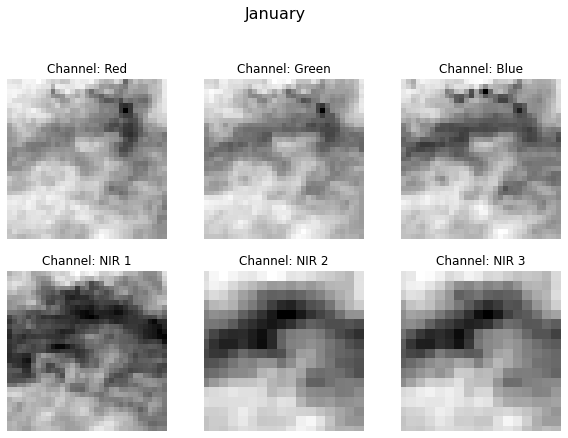

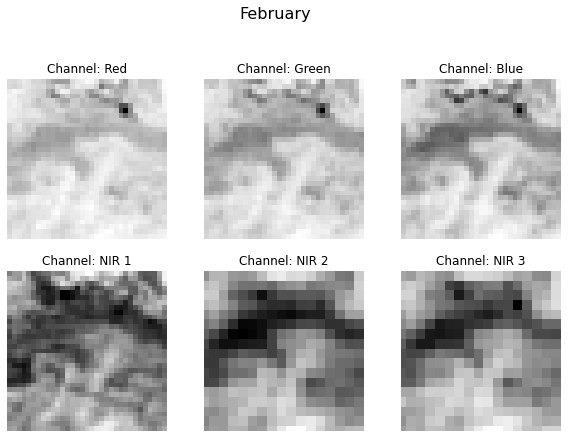

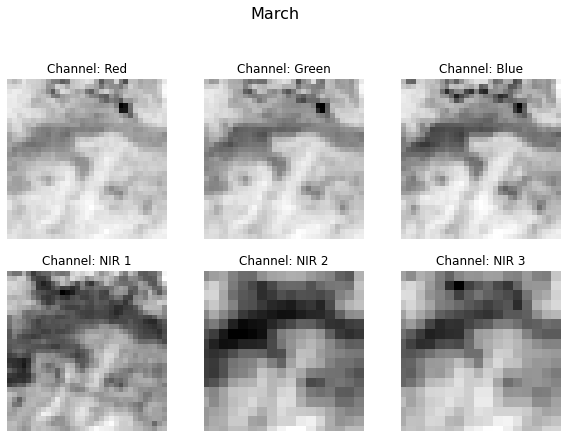

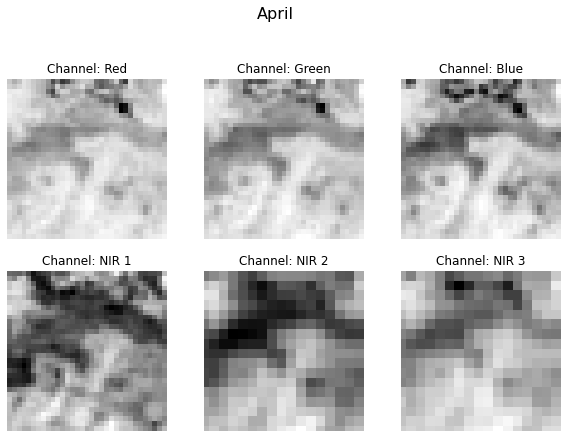

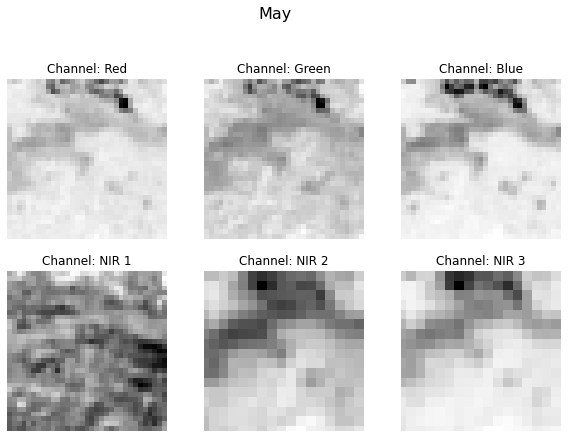

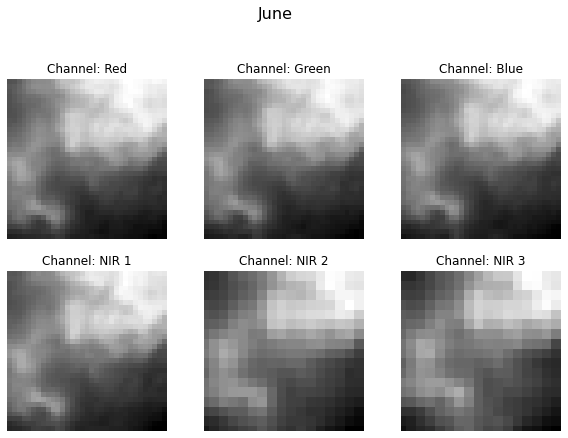

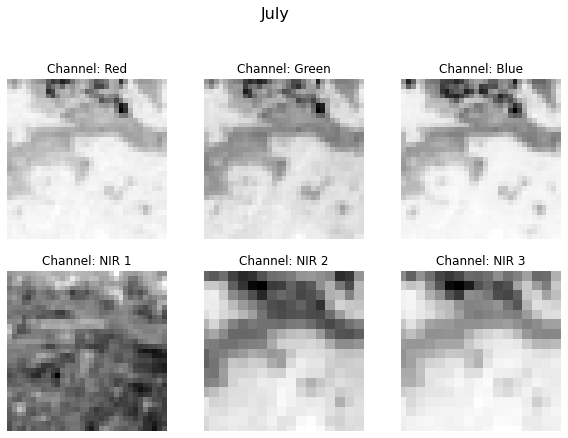

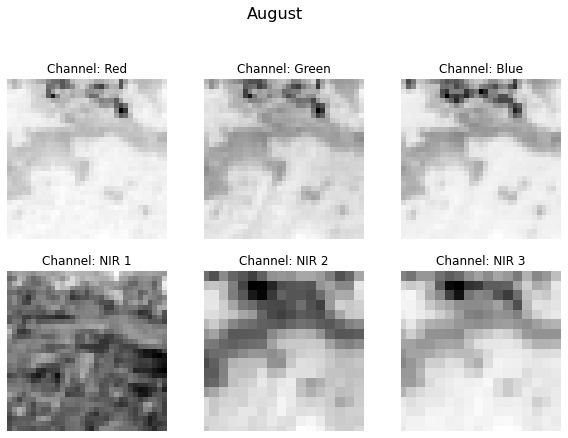

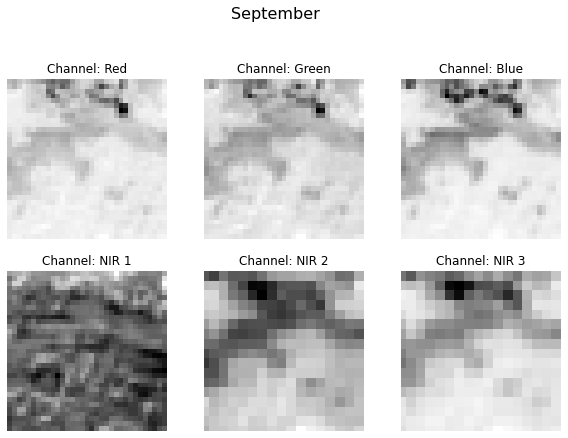

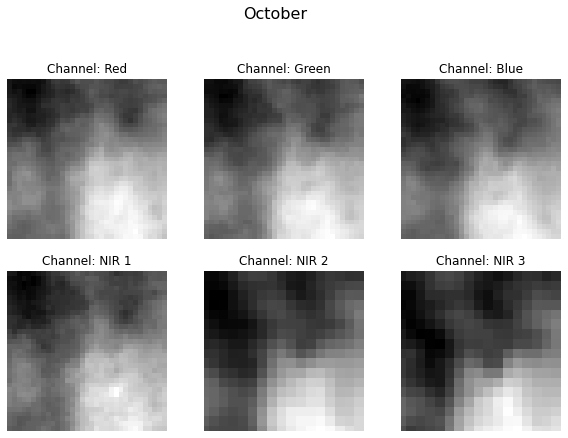

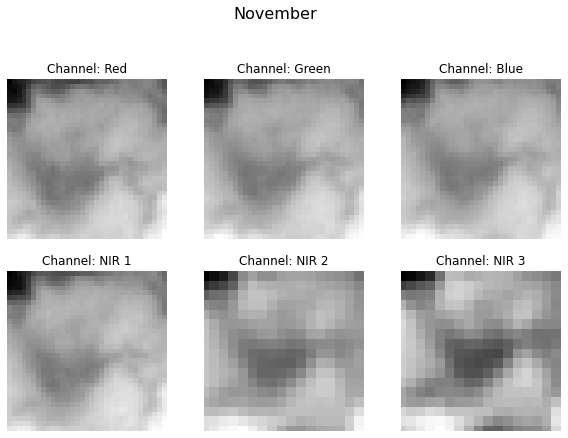

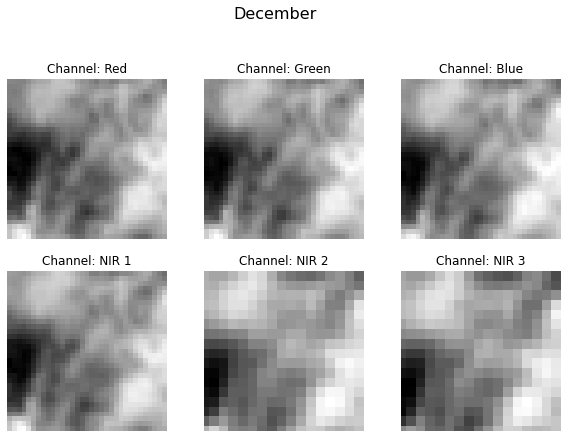

In [11]:
# Show some images

patch = 250 # patch number

print("Channels from patch no. " + str(patch))
print("Central pixel is labeled as " + class_names[lulc[patch]])

for month in range(12):
    plt.figure(figsize=(10, 10))
    for channel in range(6): #show all six channels
        ax = plt.subplot(3, 3, channel+1)
        image = bands[patch, month, :, :, channel]
        plt.imshow(image, cmap = plt.cm.binary)
        plt.title("Channel: " + channel_names[channel+1])
        plt.suptitle(calendar.month_name[month+1], size=16)
        plt.axis("off")

**Preprocessing**

In [12]:
# Generating test, validation and training sets
X = bands
y = lulc
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.20)

**Build 3D CNN Model from scratch**

adapted by: https://towardsdatascience.com/step-by-step-implementation-3d-convolutional-neural-network-in-keras-12efbdd7b130

In [14]:
base_model = Sequential() # sequential model
base_model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(12,33,33,6)))
base_model.add(MaxPooling3D(pool_size=(2, 2, 2)))
base_model.add(BatchNormalization(center=True, scale=True))
base_model.add(Dropout(0.5))
base_model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
base_model.add(MaxPooling3D(pool_size=(2, 2, 2)))
base_model.add(BatchNormalization(center=True, scale=True))
base_model.add(Dropout(0.5))
base_model.add(Flatten())
base_model.add(Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_uniform')) #leaky relu and not standard one
base_model.add(Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_uniform')) #leaky relu and not standard one
base_model.add(Dense(11, activation='softmax')) # number of outputs, in our case eleven different classes

# Compile the base_model
base_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 10, 31, 31, 32)    5216      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 5, 15, 15, 32)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 15, 15, 32)     128       
_________________________________________________________________
dropout (Dropout)            (None, 5, 15, 15, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 13, 13, 64)     55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 1, 6, 6, 64)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 6, 6, 64)       2

**Build 3D CNN Model with a pretrained model**

In [15]:
import_hub = hub.KerasLayer("https://tfhub.dev/google/remote_sensing/eurosat-resnet50/1")

In [3]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

NameError: name 'tf' is not defined

In [4]:
hub_model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=(33,33,3)),
    data_augmentation,
    import_hub,
    tf.keras.layers.Dense(11, activation="softmax"),
])

initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

hub_model.layers[0]._name = 'keras'
hub_model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), 
                  metrics=['accuracy'])
hub_model.summary()

NameError: name 'tf' is not defined

**Calculate class weights automatically** 

In [18]:
#classes = np.array([x for x in range(0,11)])
#class_weights_dict = {i : class_weights_array[i] for i in range(8)}
#dict_class_weights = dict(enumerate(clsass_weights.flatten(), 0))


class_weights_array = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
#automatic conversion to dictionarry does not work since not represented 
#classes are not included in the class_weights array

class_weights_dict = {
    0: class_weights_array[0],
    1: class_weights_array[1],
    2: class_weights_array[2],
    3: class_weights_array[3],
    4: class_weights_array[4],
    5: class_weights_array[5],
    6: 0,
    7: 0,
    8: class_weights_array[6],
    9: class_weights_array[7],
    10: 0,
}

#print(class_weights_dict)

**Fitting Models**

In [19]:
%%script false
history = base_model.fit(X_train, y_train, epochs=5, batch_size=32, 
                    validation_data=(X_val, y_val),
                    class_weight=class_weights_dict)

SyntaxError: ignored

In [21]:
#%%script false
hub_model.layers[1].trainable = False
hub_model.layers[2].trainable = False
early_stopping_cb = EarlyStopping(monitor='val_acc', patience = 15)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "pretrained_model.h5", save_best_only=True
)

for month in range(12):
    print("Train on month " + str(month))
    history = hub_model.fit(X_train[:, month, :,:, :3], y_train, epochs=5, shuffle=True, batch_size=32,
                            validation_data=(X_val[:, month, :,:, :3], y_val), 
                            callbacks=[checkpoint_cb, early_stopping_cb], 
                            class_weight=class_weights_dict)

Train on month 0
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


200/200 [==============================] - 56s 116ms/step - loss: 1.7696 - accuracy: 0.2298 - val_loss: 1.9363 - val_accuracy: 0.2338
Train on month 1
200/200 [==============================] - 21s 106ms/step - loss: 1.8321 - accuracy: 0.2069 - val_loss: 2.0677 - val_accuracy: 0.1663
Train on month 2
200/200 [==============================] - 21s 106ms/step - loss: 1.7145 - accuracy: 0.2577 - val_loss: 2.1586 - val_accuracy: 0.1181
Train on month 3
200/200 [==============================] - 22s 113ms/step - loss: 1.6176 - accuracy: 0.2764 - val_loss: 1.9273 - val_accuracy: 0.1819
Train on month 4
200/200 [==============================] - 23s 113ms/step - loss: 1.6570 - accuracy: 0.2970 - val_loss: 1.6983 - val_accuracy: 0.2375
Train on month 5
200/200 [==============================] - 23s 113ms/step - loss: 1.8365 - accuracy: 0.2102 - val_loss: 1.7103 - val_accuracy: 0.2812
Train on month 6
200/200 [==============================] - 22s 108ms/step - loss: 1.5831 - accuracy: 0.3980 - 

In [ ]:
%%script false
#model.save('../modelels/trainingData_5Epochs.h5') # save model in root directory
#model = keras.models.load_model('../modelels/trainingData_5Epochs.h5')

**Evaluation**

In [ ]:
%%script false
# Calculate loss and accuracy
base_model.evaluate(X_test, y_test)
#63/63 [==============================] - 18s 288ms/step - loss: 0.8801 - accuracy: 0.6990

# Predicitions with test-set
y_pred = base_model.predict_classes(X_test)
plt.figure(figsize=(10, 10))
print("Predictions of Channel Red in January for nine test pictures:")
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i, 0, :, :, 0], cmap = plt.cm.binary)
    plt.title("Predicition: " + str(y_pred[i]) + "; True label: " + str(y_test[i]))
    plt.axis("off")

In [ ]:
#%%script false
# Calculate loss and accuracy
hub_model.evaluate(X_test, y_test)
#63/63 [==============================] - 18s 288ms/step - loss: 0.8801 - accuracy: 0.6990

# Predicitions with test-set
y_pred = hub_model.predict_classes(X_test)
plt.figure(figsize=(10, 10))
print("Predictions of Channel Red in January for nine test pictures:")
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i, 0, :, :, 0], cmap = plt.cm.binary)
    plt.title("Predicition: " + str(y_pred[i]) + "; True label: " + str(y_test[i]))
    plt.axis("off")

In [ ]:
%%script false
#Plot accuracy and loss of train and val set
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(history.history['accuracy'], color="green")
plt.plot(history.history['val_accuracy'], color="blue")
plt.title("Accuracy", fontsize=16)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.subplot(122)
plt.plot(history.history['loss'], color="red",)
plt.plot(history.history['val_loss'], color="orange")
plt.title("Loss", fontsize=16)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

**Testing on Public Test Set**

In [ ]:
data_public_test = np.load(root_path + '/public_test.npz') # load public test set
bands_public_test = data_public_test['bands'] # extract only layer called 'bands'
print(bands_public_test.shape)

In [ ]:
# Show all 12 monthly images of the public test set

for month in range(12):
    plt.figure(figsize=(10, 10))
    for channel in range(6): #show all six channels
        ax = plt.subplot(3, 3, channel+1)
        image = bands_public_test[month, :, :, channel]
        plt.imshow(image, cmap = plt.cm.binary)
        plt.title("Channel: " + channel_names[channel+1])
        plt.suptitle(calendar.month_name[month+1], size=16)
        plt.axis("off")

**Padding**

In [ ]:
bands_public_test_pad = np.zeros(shape=(12, 532, 532, 6)) # get empty array with correct shape

# perform padding for all images (months and channels)
for month in range(12):
    for channel in range(6):
        bands_public_test_pad[month, :, :,channel] = np.pad(bands_public_test[month, :, :,channel], ((16,16),(16,16)), 'constant')

In [ ]:
# test padding by printing out the images of the public test set

for month in range(12):
    plt.figure(figsize=(10, 10))
    for channel in range(6): #show all six channels
        ax = plt.subplot(3, 3, channel+1)
        image = bands_public_test_pad[month, :, :, channel]
        plt.imshow(image)
        plt.title("Channel: " + channel_names[channel+1])
        plt.suptitle(calendar.month_name[month+1], size=16)
        plt.axis("off") 
        
print(bands_public_test_pad.shape)

In [ ]:
# add one dimension to be able feeding our model

#bands_public_test = np.expand_dims(bands_public_test, 0)
bands_public_test_pad = np.expand_dims(bands_public_test_pad, 0)
bands_public_test_pad.shape

**Naive sliding window approach**

Iterate the model over the whole public test image with stepsize one.

In [ ]:
x_coord_start = 15
x_coord_end = x_coord_start + 33

#print(current_cutout.shape) #(1, 12, 33, 33, 6)
y_pred_public_test = np.zeros(shape=(532, 532, 1)) #468 nachher?

for i in range(468):
    x_coord_end   += 1
    x_coord_start += 1
    y_coord_start = 15
    y_coord_end = y_coord_start + 33
    for j in range(468):
        y_coord_end   += 1
        y_coord_start += 1
        # pass every month & color channel 
        current_cutout = bands_public_test_pad[:, :, x_coord_start:x_coord_end, y_coord_start:y_coord_end, :]
        
        y_pred = base_model.predict_classes(current_cutout)
        y_pred_public_test[i][j] = y_pred[0]
        #print(y_pred_public_test)
        
        #Debugging
        #print("i: "+ str(i) + "  j: " + str(j)        + "  -  " +
        #      str(x_coord_start)+":"+str(x_coord_end) + "; "    +
        #      str(y_coord_start)+":"+str(y_coord_end) + "  -  " +
        #      str(int(y_pred_public_test[i][j])))
        #if(current_cutout.shape != (1, 12, 33, 33, 6)): 
            #print(str(current_cutout.shape) + "\n")

In [ ]:
%%script false
with open("y_pred_public_test.npy", "wb") as f:
    np.save(f, y_pred_public_test)

In [ ]:
%%script false
with open("y_pred_public_test.npy", "rb") as f:
    file = np.load(f)
file

In [ ]:
#https://stackoverflow.com/questions/37719304/python-imshow-set-certain-value-to-defined-color
color_map = {
    0:  np.array([  0,   0,   0]), #0: "No Data"
    1:  np.array([240, 222,  60]), #1: "Cultivated Land"
    2:  np.array([ 47, 102,  31]), #2: "Forest"
    3:  np.array([162, 232, 142]), #3: "Grassland"
    4:  np.array([162, 176, 158]), #4: "Shrubland"
    5:  np.array([ 99, 189, 224]), #5: "Water"
    6:  np.array([ 44, 209, 154]), #6: "Wetlands"
    7:  np.array([230, 189,  41]), #7: "Tundra"
    8:  np.array([237,  82,  55]), #8: "Artificial Surface"
    9:  np.array([224, 180, 132]), #9: "Bareland"
    10: np.array([189, 189, 189]), #10: "Snow and Ice"
} 

# make a 3d numpy array that has a color channel dimension   
data_3d = np.ndarray(shape=(file.shape[0], file.shape[1], 3), dtype=int)
for i in range(0, file.shape[0]):
    for j in range(0, file.shape[1]):
        data_3d[i][j] = color_map[file[j,i,0]]
        print(data_3d[i][j])

# display the plot 
fig, ax = plt.subplots(1,1)
ax.imshow(data_3d)

# add numbers to the plot 
for i in range(0, file.shape[0]):
    for j in range(0, file.shape[1]):
        c = file[j,i,0]
        ax.text(i, j, str(c), va='center', ha='center')

In [ ]:
%%script false
print(data_3d.shape)
plt.imshow(file, interpolation='none')
plt.show()